<img src="https://www.math24.net/wp-content/uploads/2019/02/double-pendulum1.svg" alt="drawing" width="300"/>

Using this as the model for the 2D pendulum - Note: we use $\theta$ instead of $\alpha$ to denote the angles.

In [19]:
import sympy as sp
import numpy as np

from IPython.display import display

from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

In [20]:
# DEFINE CONSTANTS FOR THE MODEL
g = sp.symbols("g")
l1, l2 = sp.symbols(["l1", "l2"])
m1, m2 = sp.symbols(["m1", "m2"])

# DEFINE STATE VARIABLES FOR THE SYSTEM
th1, th2 = sp.symbols(["\\theta_1", "\\theta_2"])
dth1, dth2 = sp.symbols(["\\dot{\\theta_1}", "\\dot{\\theta_2}"])
ddth1, ddth2 = sp.symbols(["\\ddot{\\theta_1}", "\\ddot{\\theta_2}"])
tau = sp.symbols("\\tau") #force input

In [21]:
#FORMULATE THE EQUATIONS OF MOTION

# positions
x1 = l1*sp.sin(th1)
y1 = -l1*sp.cos(th1)
x2 = x1 + l2*sp.sin(th2)
y2 = y1 - l2*sp.cos(th2)

# state vector q
q = sp.Matrix([[th1],[th2]])
dq = sp.Matrix([[dth1],[dth2]])
ddq = sp.Matrix([[ddth1],[ddth2]])

# coordinate transformation matrix p
p1 = sp.Matrix([x1, y1, th1])
[dx1, dy1, dth1] = p1.jacobian(q)*dq
p2 = sp.Matrix([x2, y2, th2])
[dx2, dy2, dth2] = p2.jacobian(q)*dq

# kinetic energy
T = sp.Matrix([0.5*m1*(dx1**2 + dy1**2) + 0.5*m2*(dx2**2 + dy2**2)])

# potential energy
V = sp.Matrix([m1*g*y1 + m2*g*y2])

# formulate the Lagrangian
L = T-V

# Euler-Lagrange equations
lg1 = sp.zeros(1,len(q))
for i in range(len(q)):
    dL_ddq = sp.diff(L, dq[i])
    lg1[i] = dL_ddq.jacobian(q)*dq + dL_ddq.jacobian(dq)*ddq
lg2 = L.jacobian(q)

# forces
F = sp.Matrix([0, 0, tau])
r = sp.Matrix([0, 0, th1])
J = r.jacobian(q)
Q = J.transpose()*F

eom = lg1 - lg2 - Q.transpose()

In [22]:
# DISPLAY OUR EQUATIONS OF MOTION
eom

Matrix([[\ddot{\theta_1}*(0.5*m1*(2*l1**2*sin(\theta_1)**2 + 2*l1**2*cos(\theta_1)**2) + 0.5*m2*(2*l1**2*sin(\theta_1)**2 + 2*l1**2*cos(\theta_1)**2)) + 0.5*\ddot{\theta_2}*m2*(2*l1*l2*sin(\theta_1)*sin(\theta_2) + 2*l1*l2*cos(\theta_1)*cos(\theta_2)) + 0.5*\dot{\theta_1}*m2*(2*l1*(\dot{\theta_1}*l1*sin(\theta_1) + \dot{\theta_2}*l2*sin(\theta_2))*cos(\theta_1) - 2*l1*(\dot{\theta_1}*l1*cos(\theta_1) + \dot{\theta_2}*l2*cos(\theta_2))*sin(\theta_1)) + 0.5*\dot{\theta_2}*m2*(2*\dot{\theta_2}*l1*l2*sin(\theta_1)*cos(\theta_2) - 2*\dot{\theta_2}*l1*l2*sin(\theta_2)*cos(\theta_1)) - \tau + g*l1*m1*sin(\theta_1) + g*l1*m2*sin(\theta_1) - 0.5*m2*(2*\dot{\theta_1}*l1*(\dot{\theta_1}*l1*sin(\theta_1) + \dot{\theta_2}*l2*sin(\theta_2))*cos(\theta_1) - 2*\dot{\theta_1}*l1*(\dot{\theta_1}*l1*cos(\theta_1) + \dot{\theta_2}*l2*cos(\theta_2))*sin(\theta_1)), 0.5*\ddot{\theta_1}*m2*(2*l1*l2*sin(\theta_1)*sin(\theta_2) + 2*l1*l2*cos(\theta_1)*cos(\theta_2)) + 0.5*\ddot{\theta_2}*m2*(2*l2**2*sin(\theta

In [23]:
# initial parameters
th1_0 = np.pi/4
th2_0 = 0
d_th1_0 = 0
d_th2_0 = 0

# constants for the pendulum
l1_val = 1
l2_val = 1
m1_val = 1
m2_val = 1
torque = 0

#simulation values
h = 0.02 #timestep

# initialize lists to record for animation
th1_hist = [th1_0]
th2_hist = [th2_0]
dth1_hist = [d_th1_0]
dth2_hist = [d_th2_0]
N = 300 #number of steps

parameter_values = [(g,9.81),(m1,m1_val),(m2,m2_val),(l1,l1_val),(l2,l2_val)]

sol = sp.solve(eom.subs(parameter_values), [ddth1, ddth2])
eom_fn = sp.lambdify([th1, th2, dth1, dth2, tau], sp.Matrix([sol[ddth1], sol[ddth2]]), 'numpy')

for i in range(1,N):
    # solve for the acceleration
    acc = eom_fn(th1_hist[i-1], th2_hist[i-1], dth1_hist[i-1], dth2_hist[i-1], torque)
    # integrate for the next velocity and position    
    dth1_hist.append(float(dth1_hist[i-1] + h*acc[0]))
    dth2_hist.append(float(dth2_hist[i-1] + h*acc[1]))
    th1_hist.append(float(th1_hist[i-1] + h*dth1_hist[i]))
    th2_hist.append(float(th2_hist[i-1] + h*dth2_hist[i]))

In [24]:
# ANIMATE THE PENDULUM SWINGING FREELY (to test)
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML

fig, ax = plt.subplots(1,1, figsize=(10, 10)) #create axes

def plot_pendulum(i, th1, th2, ax): #update function for animation
    ax.clear()
    ax.set_xlim([-2,2])
    ax.set_ylim([-3,1])
    #plot top
    L1bottomx = l1_val*np.sin(th1[i])
    L1bottomy = -l1_val*np.cos(th1[i])
    ax.plot([0,L1bottomx],[0,L1bottomy], linewidth=5, solid_capstyle='round', zorder=1)
    #plot bottom
    L2bottomx = L1bottomx + l2_val*np.sin(th2[i])
    L2bottomy = L1bottomy - l2_val*np.cos(th2[i]) 
    ax.plot([L1bottomx,L2bottomx],[L1bottomy,L2bottomy], linewidth=5, solid_capstyle='round', zorder=1)
    #plot masses
    ax.scatter([L1bottomx,L2bottomx],[L1bottomy,L2bottomy], s=500, c='k', zorder=2)
    
update = lambda i: plot_pendulum(i, th1_hist, th2_hist, ax)
animate = ani.FuncAnimation(fig, update, range(N), interval = h*1000, repeat=True)
plt.close("all")
HTML(animate.to_html5_video())

In [25]:
m = ConcreteModel(name = "Pendulum")

# SETS
N = 250
m.N = RangeSet(N) #number of points in trajectory
m.L = RangeSet(2) #number of links


# PARAMETERS
m.g = Param(initialize=9.81) #gravity
m.h = Param(initialize=0.02) #timestep
m.m = Param(m.L, initialize=1.0) #mass of links
m.len = Param(m.L, initialize = 1.0) #length of links


# VARIABLES
m.th = Var(m.N, m.L, bounds=(-np.pi/2,3/2*np.pi)) #position
m.dth = Var(m.N, m.L) #velocity
m.ddth = Var(m.N, m.L) #acceleration

m.Tc = Var(m.N) #torque at 2nd joint



# Integration constraints
def backwards_euler_pos(m,n,l): # for positions
    if n > 1:
        return m.th[n,l] == m.th[n-1,l] + m.h*m.dth[n,l]
    else:
        return Constraint.Skip #use this to leave out members of a set that the constraint doesn't apply to (i.e. the first point)
m.integrate_p = Constraint(m.N, m.L, rule = backwards_euler_pos)

def backwards_euler_vel(m,n,l): # for velocities
    if n > 1:
        return m.dth[n,l] == m.dth[n-1,l] + m.h*m.ddth[n,l]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.L, rule = backwards_euler_vel)



#Lambdify the EOM
func_map = {'sin':sin, 'cos':cos} 
sym_list = [g, th1, th2, dth1, dth2, ddth1, ddth2, tau, m1, m2, l1, l2] # list of the symbols that will be substituted with inputs
lamb_eom_1 = sp.lambdify(sym_list, eom[0], modules=[func_map])
lamb_eom_2 = sp.lambdify(sym_list, eom[1], modules=[func_map])

#create the constraints
def eom1(m,n): # for theta1
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g, m.th[n,1], m.th[n,2], m.dth[n,1], m.dth[n,2], m.ddth[n,1], m.ddth[n,2], m.Tc[n], m.m[1], m.m[2], m.len[1], m.len[2]] 
    return lamb_eom_1(*var_list) == 0
m.eom1 = Constraint(m.N, rule=eom1)

def eom2(m,n): # for theta2
    var_list = [m.g, m.th[n,1], m.th[n,2], m.dth[n,1], m.dth[n,2], m.ddth[n,1], m.ddth[n,2], m.Tc[n], m.m[1], m.m[2], m.len[1], m.len[2]] 
    return lamb_eom_2(*var_list) == 0
m.eom2 = Constraint(m.N, rule=eom2)


def obj(m):
    torque_sum = 0
    for n in range(1,N+1):
            torque_sum += m.Tc[n]**2
    return torque_sum
m.obj = Objective(rule = obj)


# initialization
for n in range(1,N+1):
    m.Tc[n].value = 0
    
    for l in range(1,3):
        m.th[n,l].value = n/N * np.random.uniform(-np.pi, np.pi)
        m.dth[n,l].value = 0
        m.ddth[n,l].value = 0
        
        
# Boundary conditions
# you should to do these after initialization so the values you want to be fixed don't accidentally end up being changed

# initial condition
m.th[1,1].fixed = True # if a variable's value is fixed, the solver treats it like a parameter
m.th[1,1].value = 0
m.th[1,2].fixed = True
m.th[1,2].value = 0

m.dth[1,1].fixed = True 
m.dth[1,1].value = 0
m.dth[1,2].fixed = True
m.dth[1,2].value = 0

# final condition
m.th[N,1].fixed = True
m.th[N,1].value = np.pi
m.th[N,2].fixed = True
m.th[N,2].value = np.pi

m.dth[N,1].fixed = True 
m.dth[N,1].value = 0
m.dth[N,2].fixed = True
m.dth[N,2].value = 0




In [26]:
# solving
opt = SolverFactory('ipopt') # standard issue, garden variety ipopt

# solver options
opt.options["print_level"] = 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 30000 # maximum number of iterations
opt.options["max_cpu_time"] = 300 # maximum cpu time in seconds
opt.options["Tol"] = 1e-12 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.
    
results = opt.solve(m, tee = False)

# For debugging:
print(results.solver.status) # tells you if the solver had any errors/ warnings
print(results.solver.termination_condition) # tells you if the solution was (locally) optimal, feasible, or neither.

# If you want a full print-out of everything going on with your model, use:
#m.pprint() 

# This is your best friend when it comes to figuring out why something's not converging, why the solution looks weird, etc.
# It's probably most handy if you print it to a file:
#instance.pprint(filename='blah.txt')

# You can also pretty print individual elements of the model. e.g.
#m.th.pprint()

ok
optimal


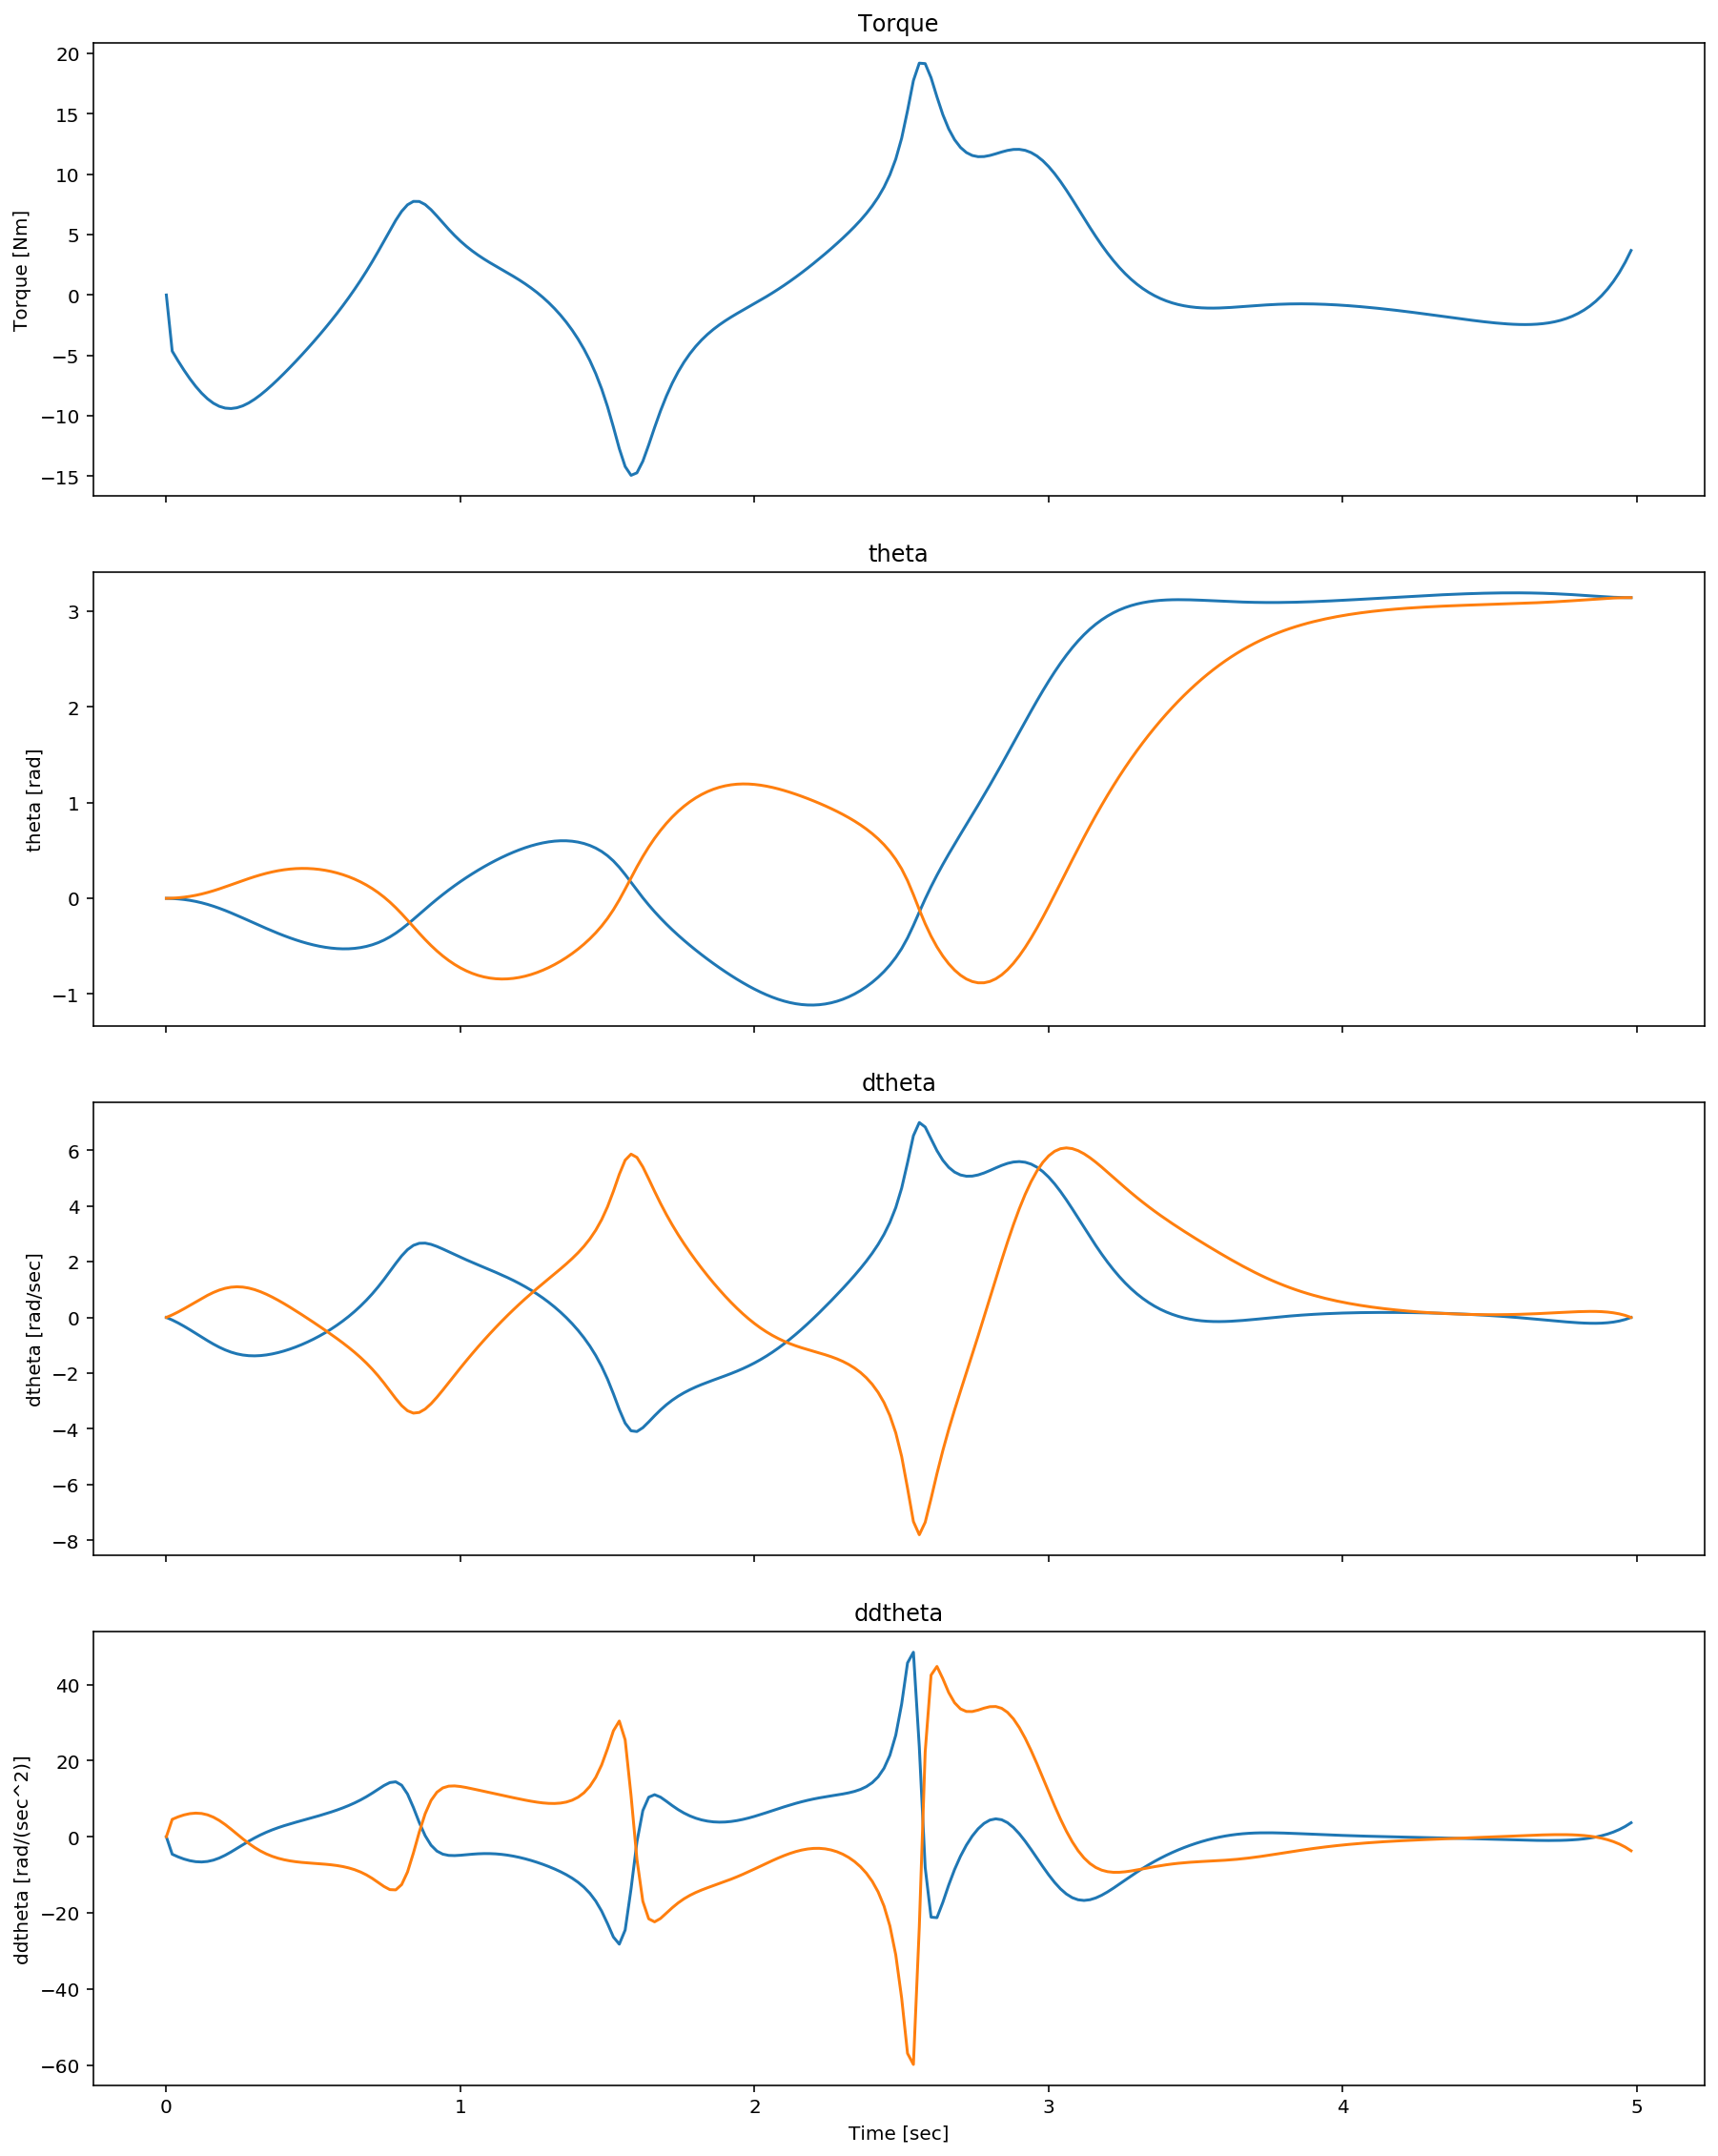

In [32]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(4,1, figsize=(13, 16), sharex=True) #create axes
fig.tight_layout(pad=3.0)
time = [i*m.h for i in range(N)]
plt.xlabel('Time [sec]')
#Torque
torques = [i.value for i in m.Tc.values()]
ax1.plot(time, torques)
ax1.set_ylabel('Torque [Nm]')
ax1.set_title('Torque')
#Pos
for i in range(1,len(m.L)+1):
    theta = [m.th[(j, i)].value for j in range(1, len(m.N)+1)]
    ax2.plot(time, theta)
    ax2.set_ylabel('theta [rad]')
    ax2.set_title('theta')
#Vel
for i in range(1,len(m.L)+1):
    dtheta = [m.dth[(j, i)].value for j in range(1, len(m.N)+1)]
    ax3.plot(time, dtheta)
    ax3.set_ylabel('dtheta [rad/sec]')
    ax3.set_title('dtheta')
#Acc    
for i in range(1,len(m.L)+1):
    ddtheta = [m.ddth[(j, i)].value for j in range(1, len(m.N)+1)]
    ax4.plot(time, ddtheta)
    ax4.set_ylabel('ddtheta [rad/(sec^2)]')
    ax4.set_title('ddtheta')

In [28]:
#animate it
fig1, ax1 = plt.subplots(1,1, figsize=(10, 10)) #create axes

def plot_pendulum(i, m, ax): #update function for animation
    ax.clear()
    ax.set_xlim([-3,3])
    ax.set_ylim([-3,3])
    
    #plot link 1
    L1bottomx = m.len[1]*np.sin(m.th[i, 1].value)
    L1bottomy = -m.len[1]*np.cos(m.th[i, 1].value)
    ax.plot([0,L1bottomx],[0,L1bottomy], linewidth=5, solid_capstyle='round', zorder=1)
    
    #plot link 2
    L2bottomx = L1bottomx + m.len[2]*np.sin(m.th[i, 2].value)
    L2bottomy = L1bottomy - m.len[2]*np.cos(m.th[i, 2].value) 
    ax.plot([L1bottomx,L2bottomx],[L1bottomy,L2bottomy], linewidth=5, solid_capstyle='round', zorder=1)
    
    ax.scatter([L1bottomx,L2bottomx],[L1bottomy,L2bottomy], s=500, c='k', zorder=2)
 
    
update = lambda i: plot_pendulum(i, m, ax1) #lambdify update function
animate = ani.FuncAnimation(fig1, update, range(1, N+1), interval = m.h*1000, repeat=True)
plt.close('all')
HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook

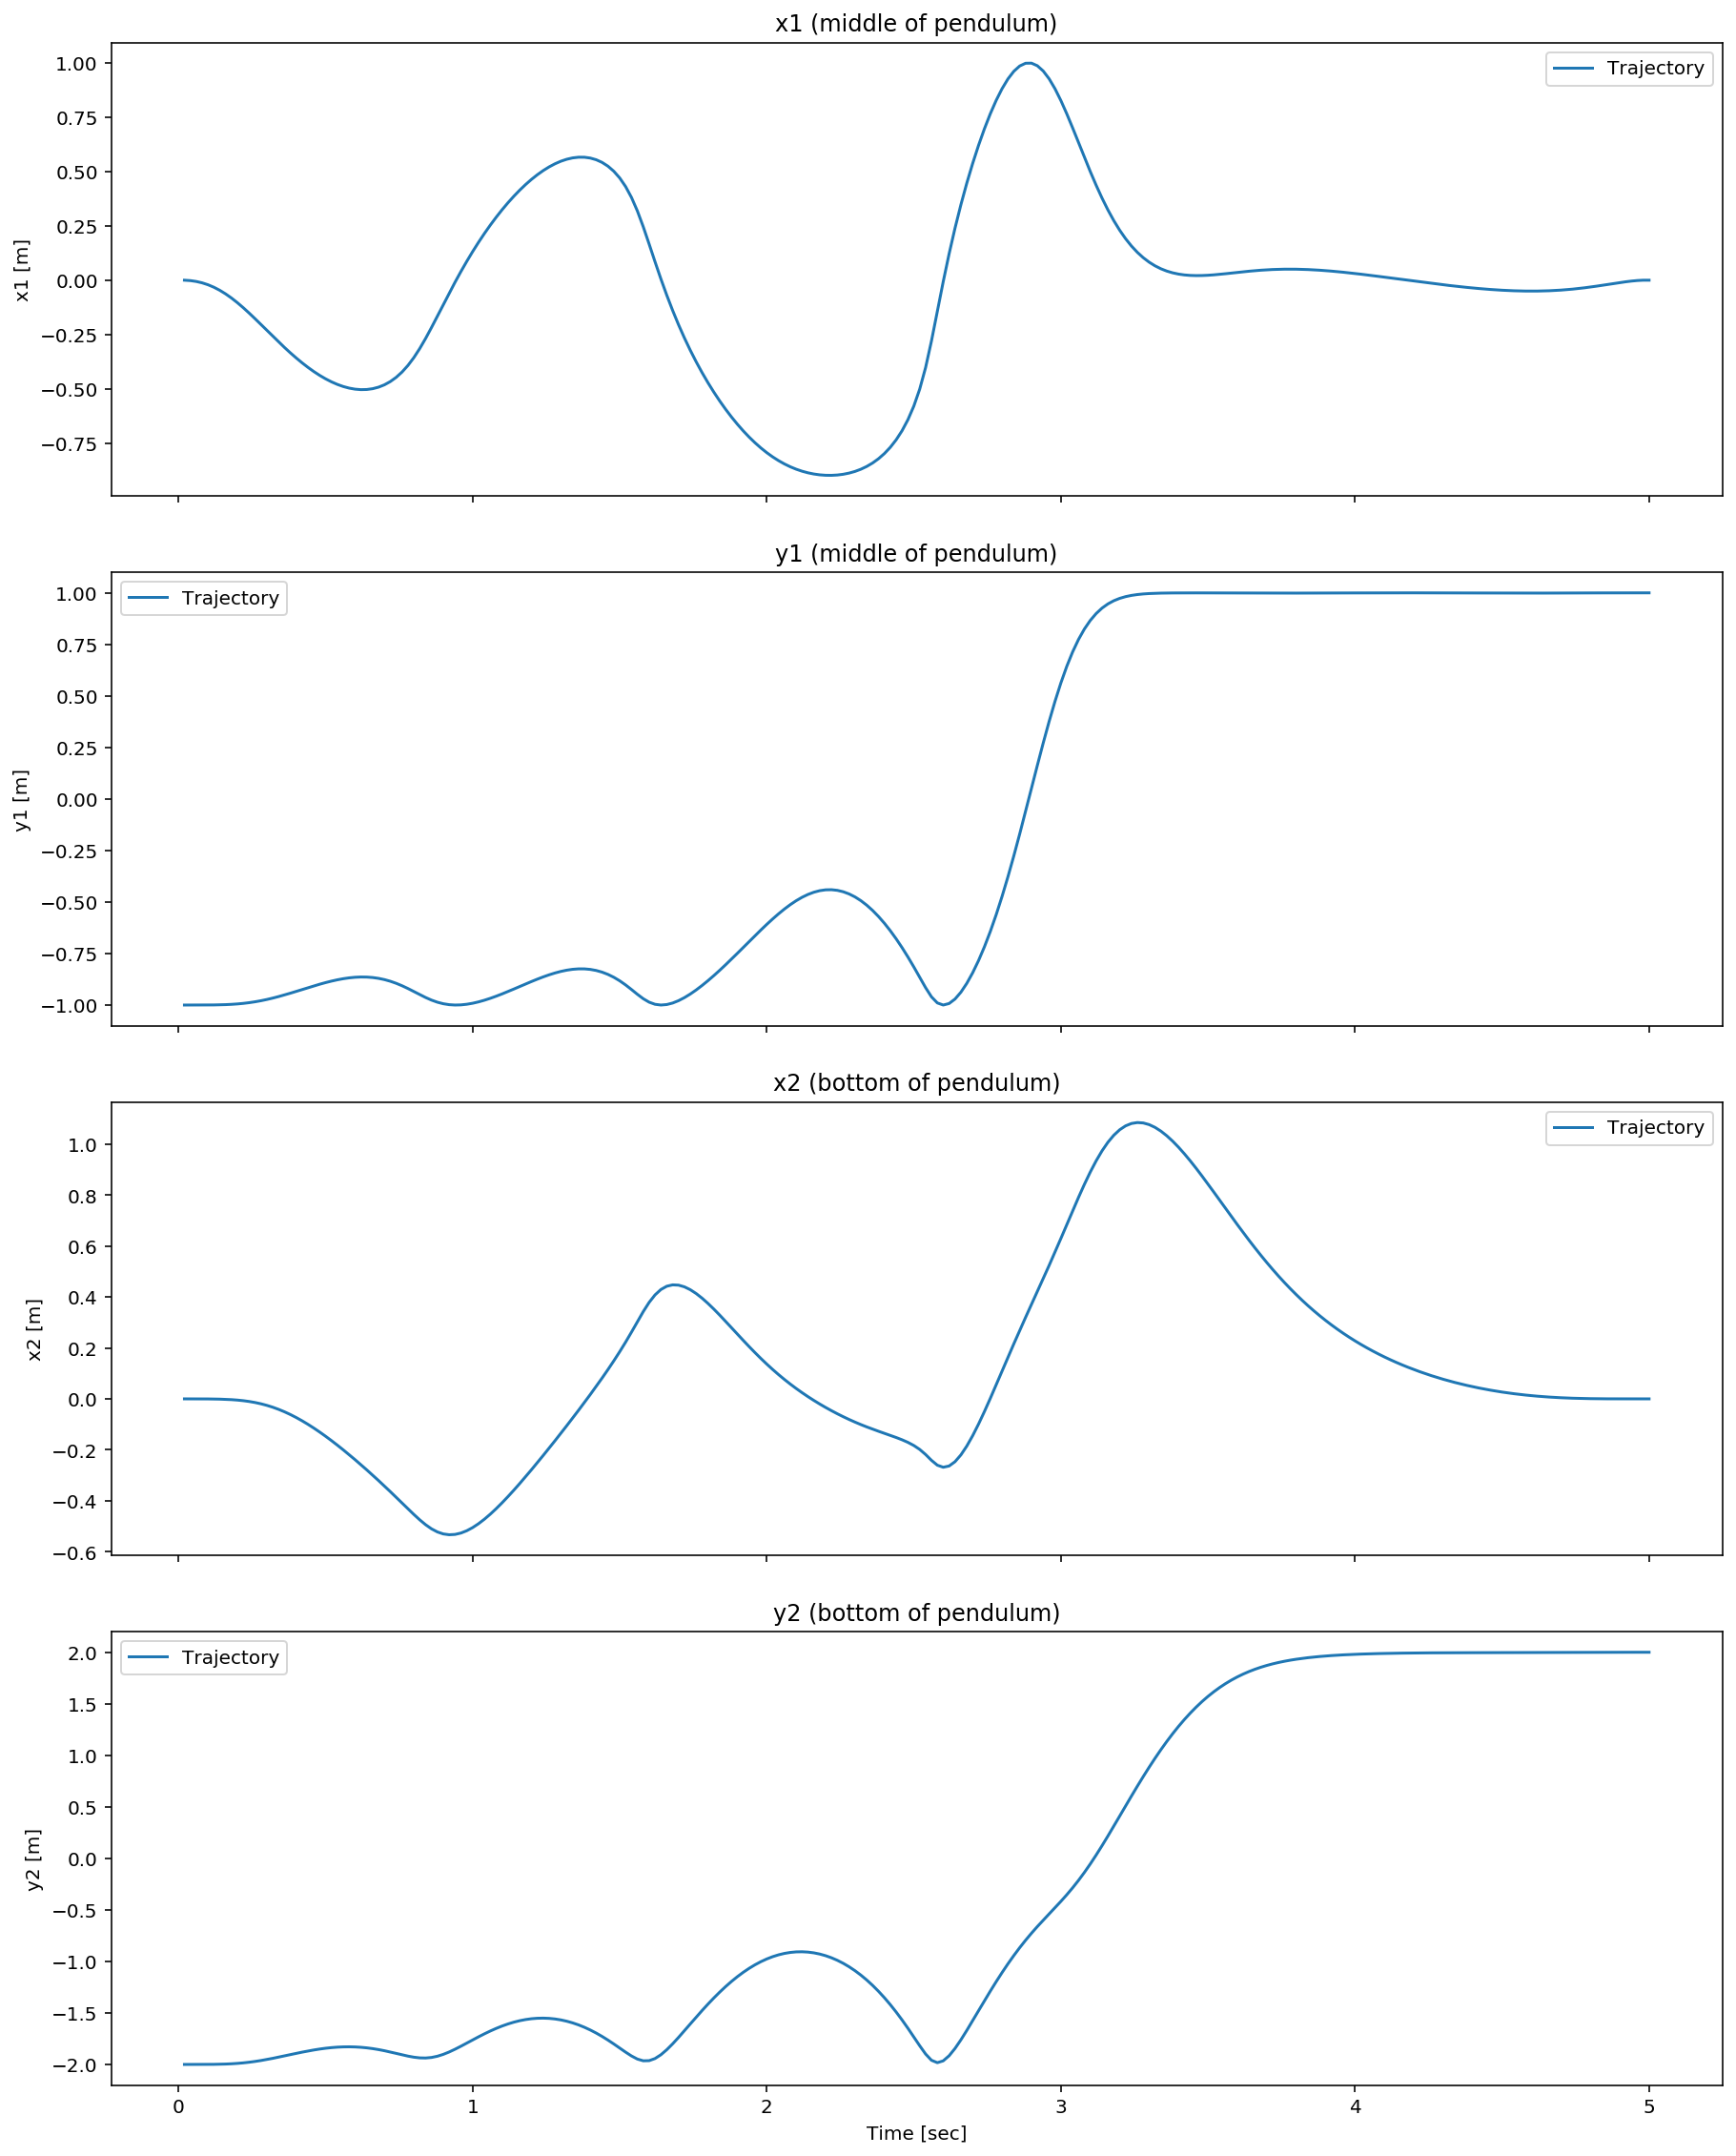

In [31]:
import pickle

theta_1 = [m.th[(i, 1)].value for i in range(1, N+1)]
theta_2 = [m.th[(i, 2)].value for i in range(1, N+1)]
dtheta_1 = [m.dth[(i, 1)].value for i in range(1, N+1)]
dtheta_2 = [m.dth[(i, 2)].value for i in range(1, N+1)]
ddtheta_1 = [m.ddth[(i, 1)].value for i in range(1, N+1)]
ddtheta_2 = [m.ddth[(i, 2)].value for i in range(1, N+1)]
torque = [m.Tc[(i)].value for i in range(1, N+1)]


observed_x1 = l1_val*np.sin(theta_1)
observed_y1 = -l1_val*np.cos(theta_1)
observed_x2 = observed_x1 + l2_val*np.sin(theta_2)
observed_y2 = observed_y1 - l2_val*np.cos(theta_2)

with open("measurements.pickle", "wb") as f:
    pickle.dump([observed_x1, observed_y1, observed_x2, observed_y2],f)
with open("states.pickle", "wb") as f:
    pickle.dump([theta_1, theta_2, dtheta_1, dtheta_2, ddtheta_1, ddtheta_2, torque],f)

fig, [ax1, ax2, ax3, ax4] = plt.subplots(4,1, figsize=(13, 16), sharex=True) #create axes
fig.tight_layout(pad=3.0)
time = [i*h for i in range(1, N+1)]
plt.xlabel('Time [sec]')

ax1.plot(time, observed_x1, label="Trajectory")
ax1.set_ylabel('x1 [m]')
ax1.set_title('x1 (middle of pendulum)')
ax1.legend()

ax2.plot(time, observed_y1, label="Trajectory")
ax2.set_ylabel('y1 [m]')
ax2.set_title('y1 (middle of pendulum)')
ax2.legend()

ax3.plot(time, observed_x2, label="Trajectory")
ax3.set_ylabel('x2 [m]')
ax3.set_title('x2 (bottom of pendulum)')
ax3.legend()

ax4.plot(time, observed_y2, label="Trajectory")
ax4.set_ylabel('y2 [m]')
ax4.set_title('y2 (bottom of pendulum)')
ax4.legend()